Data Mining : Case Study
========================
**Data Source** : Armed Conflict Location & Event Data Project (ACLED)<br>
**Data Link** : <a href = "http://www.acleddata.com/asia-data/"> ACLED Asia </a><br>
**Dataset Description** : <a href = "http://www.acleddata.com/wp-content/uploads/2016/01/ACLED_User-Guide_2016.pdf"> ACLED User Guide </a><br>

**Task** : Predicting the type of ***Armed Conflict Event*** based on Actors Involved, Location - Country and Administration, Source of Information and fatalities recorded due to the event using most effective classifier based on various performance measures.

**Table of Contents** :
<ul> 
<li> Exploratory Data Analysis</li>
<ul>
<li> Univariate</li>
<li> Bivariate</li>
</ul>
<li> Data Preprocessing </li>
<ul>
<li> Missing Value handling </li>
<li> Dimensionality Reduction</li>
<li> Data Encoding</li>
</ul>
<li> Classification </li>
<ul>
<li>Naive Bayes</li>
<li> Logistic Regression</li>
<li> k-nearest Neighbour</li>
<li> Decision Tree</li>
<li> SVM </li>
</ul>
<li> Evaluating Performance </li>
<ul>
<li> Accuracy</li>
<li> Precision</li>
<li> Recall</li>
<li> F1-Score</li>
</ul>
<li> Visualization on geographical map</li>
</ul>

In [1]:
# libraries for EDA
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#libraries for Data Preprocessing
import pandas as pd
import numpy as np
import scipy as sc
import itertools

#libraries for Data Mining - Classification
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

#library for plotting crimes on Asia map
from mpl_toolkits.basemap import Basemap

#library to suppress warnings 
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

#import data
data = pd.read_csv("acled.csv")

EXPLORATORY DATA ANALYSIS
=========================

In [2]:
#Count null values for all columns
data.isnull().sum()

GWNO                   0
EVENT_ID_CNTY          0
EVENT_ID_NO_CNTY       0
EVENT_DATE             0
YEAR                   0
TIME_PRECISION         0
EVENT_TYPE             0
ACTOR1                 0
ALLY_ACTOR_1        5516
INTER1                 0
ACTOR2              6338
ALLY_ACTOR_2        9529
INTER2                 0
INTERACTION            0
COUNTRY                0
ADMIN1                 0
ADMIN2               246
ADMIN3               727
LOCATION               0
LATITUDE               0
LONGITUDE              0
GEO_PRECISION          0
SOURCE                 0
NOTES                  0
FATALITIES             0
dtype: int64

In [3]:
#map categorical Perpetrator-Respondent integers to Values
inter_dict = {0:'None',
             1:'Government or mutinous force',
             2:'Rebel force',
             3:'Political militia',
             4:'Ethnic militia',
             5:'Rioters',
             6:'Protesters',
             7:'Civilians',
             8:'Outside/external force'}

crimes = data.replace({'INTER1':inter_dict})
crimes = crimes.replace({'INTER2':inter_dict})

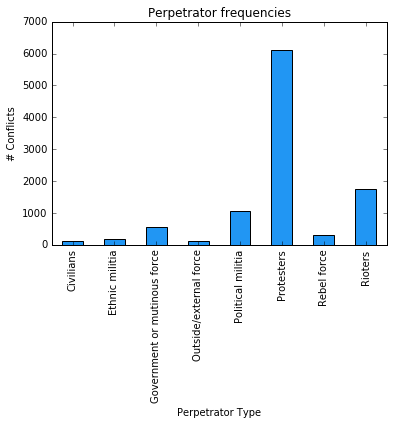

In [4]:
#plot Perpetrator Category distribution
in_table1 = pd.crosstab(index = crimes['INTER1'], columns = 'Perpetrator')
plt1 = in_table1.plot(kind='bar',color='#2196f3')
plt1.set(ylabel="# Conflicts", xlabel="Perpetrator Type", title="Perpetrator frequencies")
plt1.legend_.remove()

**Inference** : Majority of groups or individuals who are the ones to attack are Protestors, Rioters or Political Militia

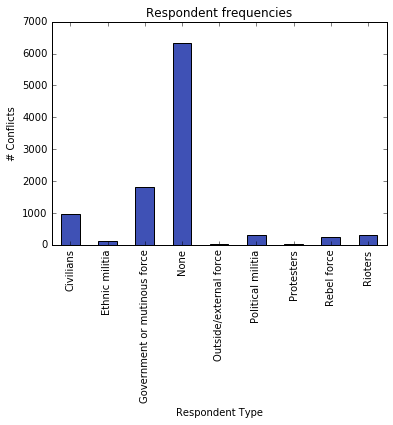

In [5]:
#plot Respondent Category distribution
in_table2 = pd.crosstab(index = crimes['INTER2'], columns = 'Respondent')
plt2 = in_table2.plot(kind='bar', color = '#3f51b5')
plt2.set(ylabel="# Conflicts", xlabel="Respondent Type", title="Respondent frequencies")
plt2.legend_.remove()

**Inference** : Many of groups or individuals who are the ones to respond to any attack are Govt. or mutinuous forces and Civilians whereas majority of Attack go unresponded.

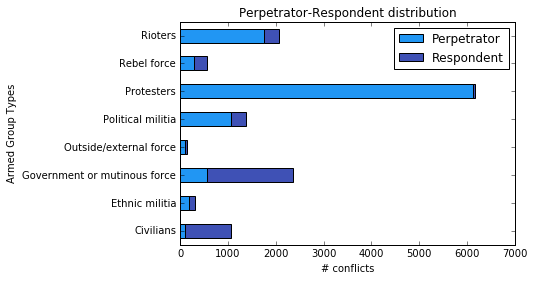

In [6]:
# plot attack-respond distribution for each group
in_table = pd.concat([in_table1,in_table2] , axis = 1)
in_table = in_table.dropna()
in_table.columns.name = ''
in_table['Perpetrator'] = in_table['Perpetrator'].astype('int')
in_table['Respondent'] = in_table['Respondent'].astype('int')
plt3 = in_table.plot(kind='barh', color=('#2196f3','#3f51b5'), stacked=True)
plt3.set(ylabel="Armed Group Types", xlabel="# conflicts", title="Perpetrator-Respondent distribution")

**Inference** : 
<li> Involvement of Protestors, Rioters and Political Militia in most of the conflicts is as the attackers.</li>
<li> Involvement of Govt. & mutinous forces and civilians is as the respondents</li>
<li> External forces, Rebel forces & Ethnic Militia are equally involved as attackers and respondents</li>

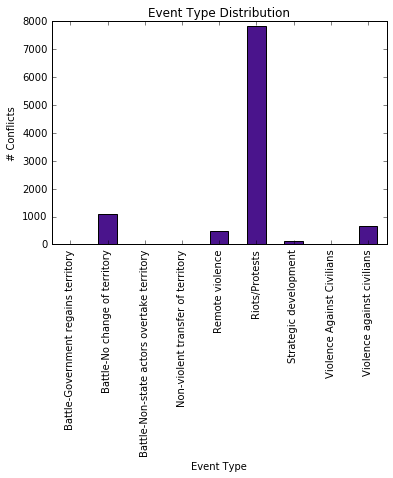

In [7]:
#event type distribution
et_table = pd.crosstab(index = crimes['EVENT_TYPE'], columns = 'events')
et_table = et_table.dropna()
et_table['events'] = et_table['events'].astype('int')
et_table.columns.name = ''
plt4 = et_table.plot(kind='bar', color = '#4a148c')
plt4.set(ylabel="# Conflicts", xlabel="Event Type", title="Event Type Distribution")
plt4.legend_.remove()

**Inference** : 
<li>The Event Type distribution goes hand-in-hand with the previous one. Most of the participant being rioter/protestors, majority of conflicts areriots/protests.</li>
<li>Three event types have very low support:</li>

In [8]:
#merge low support events with similar high supports ones
event_dict = {'Battle-Government regains territory':'Battle',
 'Battle-No change of territory':'Battle',
 'Battle-Non-state actors overtake territory':'Battle',
 'Non-violent transfer of territory':'None',
 'Violence against civilians':'Violence Against Civilians'}

crimes2 = crimes.replace({'EVENT_TYPE':event_dict})
crimes2 = crimes2[crimes2.EVENT_TYPE != 'None']

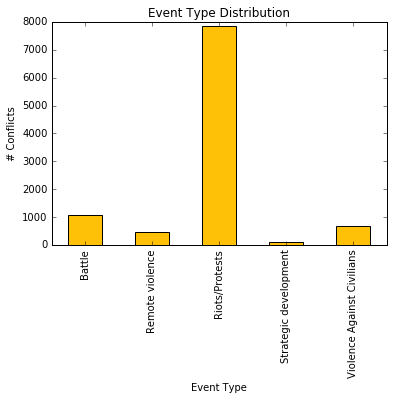

In [9]:
#Event type distribution after merging
et_table = pd.crosstab(index = crimes2['EVENT_TYPE'], columns = 'EVENTS')
et_table = et_table.dropna()
et_table['EVENTS'] = et_table['EVENTS'].astype('int')
et_table.columns.name = ''
plt5 = et_table.plot(kind='bar', color = '#ffc107')
plt5.set(ylabel="# Conflicts", xlabel="Event Type", title="Event Type Distribution")
plt5.legend_.remove()

In [10]:
#Summary Statistics for Fatalities
crimes2['FATALITIES'].describe()

count    10192.000000
mean         0.477531
std          3.000063
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        115.000000
Name: FATALITIES, dtype: float64

**Inference** : Less than 25% conflicts result in fatalities.

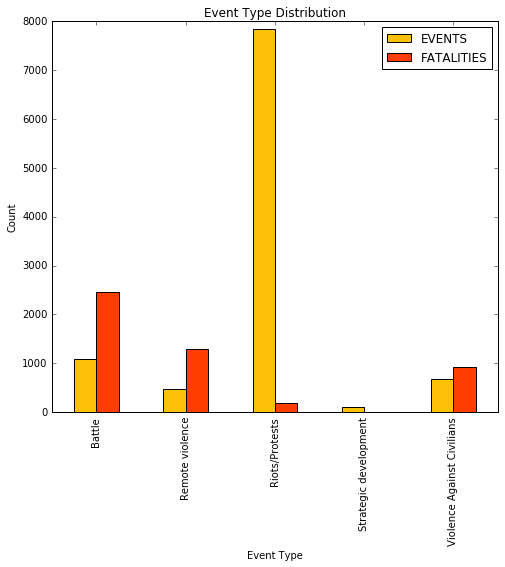

In [11]:
#Event count and fatalities by event type distribution
et_f= crimes2.groupby('EVENT_TYPE').FATALITIES.sum()
et_f2 = pd.concat([et_table,et_f] , axis = 1)
plt6 = et_f2.plot(kind='bar', figsize=(8,7), color = ['#ffc107' ,'#ff3d00' ])
plt6.set(ylabel="Count", xlabel="Event Type", title="Event Type Distribution")

**Inference** : 
<li> Count of Riots or Protests, despite of being the highest, contributes extremely low to the fatalities</li>
<li> No of Battles and Remote Violence events being low, they still account for majority of fatalities.</li>

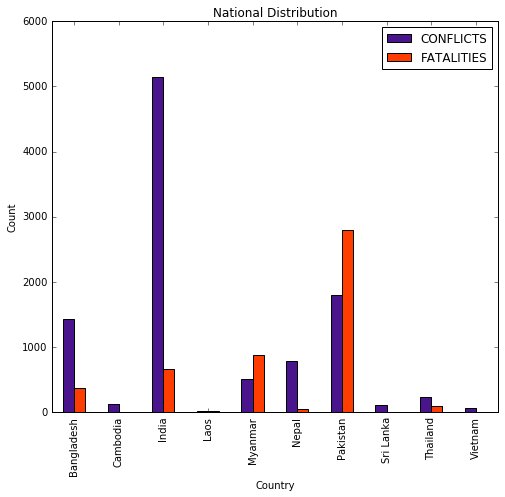

In [12]:
#conflict and fatalities distribution by Country
cnt_c = pd.crosstab(index = crimes2['COUNTRY'], columns = 'CONFLICTS')
cnt_f= crimes2.groupby('COUNTRY').FATALITIES.sum()
cnt_table = pd.concat([cnt_c,cnt_f] , axis = 1)
cnt = cnt_table.dropna()
cnt.columns.name = ''
plt7 = cnt_table.plot(kind='bar', figsize=(8,7), color = ['#4a148c','#ff3d00'])
plt7.set(ylabel="Count", xlabel="Country", title="National Distribution")

**Inference** : 
<li>Count of conflicts is poorly related to the fatalities across countries</li>
<li>Bangladesh and India have high conflict rate but low fatalities recorded</li>
<li>Pakistan has relatively high conflict rate and further higher fatalities count(highest of all nations)</li>

DATA PREPROCESSING
==================

Remove following columns for the purpose of dimensionality reduction:
<li>GWNO - ID Column</li>
<li>EVENT_ID_CNTY - ID Column</li>
<li>EVENT_ID_NO_CNTY - ID Column</li>
<li>YEAR - Same value for all records. The dataset is corresponding to event in year 2015 only.</li>
<li>TIME_PRECISION - Necessary only for time series analysis which is out of scope for our analysis.</li>
<li>ACTOR1 - Too many Nominal values. Unusable.</li>
<li>ALLY_ACTOR_1 - Many missing values. No pattern derivable.</li>
<li>ACTOR2 - Many missing values. No pattern derivable.</li>
<li>ALLY_ACTOR_2 - Many missing values. No pattern derivable.</li>
<li>GEO_PRECISION - Not required.</li>
<li>SOURCE - Too many Nominal values. Unusable.</li>
<br>
Fill empty values with value **None** as they only occur in categorical attributes which can't be predicted or replaced.

In [13]:
crimes3 = crimes2.drop(['GWNO','EVENT_ID_CNTY','EVENT_ID_NO_CNTY','YEAR','TIME_PRECISION','INTERACTION','GEO_PRECISION'], axis=1)
crimes3 = crimes3.fillna('None')
list(crimes3.columns.values)

['EVENT_DATE',
 'EVENT_TYPE',
 'ACTOR1',
 'ALLY_ACTOR_1',
 'INTER1',
 'ACTOR2',
 'ALLY_ACTOR_2',
 'INTER2',
 'COUNTRY',
 'ADMIN1',
 'ADMIN2',
 'ADMIN3',
 'LOCATION',
 'LATITUDE',
 'LONGITUDE',
 'SOURCE',
 'NOTES',
 'FATALITIES']

In [14]:
#make dummy variables for categorical variables - INTER1(Perpetrator Type) and INTER2(Respondent Type)
dummie = pd.get_dummies(crimes3, prefix_sep='', prefix='', columns=['INTER2'])
dummie = pd.get_dummies(dummie, prefix_sep='', prefix='', columns=['INTER1'])
list(dummie.columns.values)

['EVENT_DATE',
 'EVENT_TYPE',
 'ACTOR1',
 'ALLY_ACTOR_1',
 'ACTOR2',
 'ALLY_ACTOR_2',
 'COUNTRY',
 'ADMIN1',
 'ADMIN2',
 'ADMIN3',
 'LOCATION',
 'LATITUDE',
 'LONGITUDE',
 'SOURCE',
 'NOTES',
 'FATALITIES',
 'Civilians',
 'Ethnic militia',
 'Government or mutinous force',
 'None',
 'Outside/external force',
 'Political militia',
 'Protesters',
 'Rebel force',
 'Rioters',
 'Civilians',
 'Ethnic militia',
 'Government or mutinous force',
 'Outside/external force',
 'Political militia',
 'Protesters',
 'Rebel force',
 'Rioters']

In [15]:
#Aggregate attribute sets formed above
dummie2 = dummie.groupby(dummie.columns, axis=1).sum()
list(dummie2.columns.values)

['ACTOR1',
 'ACTOR2',
 'ADMIN1',
 'ADMIN2',
 'ADMIN3',
 'ALLY_ACTOR_1',
 'ALLY_ACTOR_2',
 'COUNTRY',
 'Civilians',
 'EVENT_DATE',
 'EVENT_TYPE',
 'Ethnic militia',
 'FATALITIES',
 'Government or mutinous force',
 'LATITUDE',
 'LOCATION',
 'LONGITUDE',
 'NOTES',
 'None',
 'Outside/external force',
 'Political militia',
 'Protesters',
 'Rebel force',
 'Rioters',
 'SOURCE']

In [16]:
#make dummy variable for categorical variable - EVENT_TYPE
df = pd.get_dummies(dummie2, prefix_sep='', prefix='ET-', columns=['EVENT_TYPE'])
list(df.columns.values)

['ACTOR1',
 'ACTOR2',
 'ADMIN1',
 'ADMIN2',
 'ADMIN3',
 'ALLY_ACTOR_1',
 'ALLY_ACTOR_2',
 'COUNTRY',
 'Civilians',
 'EVENT_DATE',
 'Ethnic militia',
 'FATALITIES',
 'Government or mutinous force',
 'LATITUDE',
 'LOCATION',
 'LONGITUDE',
 'NOTES',
 'None',
 'Outside/external force',
 'Political militia',
 'Protesters',
 'Rebel force',
 'Rioters',
 'SOURCE',
 'ET-Battle',
 'ET-Remote violence',
 'ET-Riots/Protests',
 'ET-Strategic development',
 'ET-Violence Against Civilians']

In [17]:
#Correlation Matrix
dummie2.corr()

,Civilians,Ethnic militia,FATALITIES,Government or mutinous force,LATITUDE,LONGITUDE,None,Outside/external force,Political militia,Protesters,Rebel force,Rioters
Civilians,1.000000,0.023461,0.067501,-0.109863,0.000277,0.112920,-0.438793,0.026081,0.327713,-0.420082,0.073720,0.034137
Ethnic militia,0.023461,1.000000,0.024112,-0.049826,-0.005742,0.098913,-0.172179,-0.009341,-0.026136,-0.166230,-0.014965,-0.058550
FATALITIES,0.067501,0.024112,1.000000,0.178023,0.091912,-0.044731,-0.203576,0.046784,0.147304,-0.194287,0.251576,-0.049706
Government or mutinous force,-0.109863,-0.049826,0.178023,1.000000,0.083945,0.109454,-0.703174,0.123516,0.208342,-0.456463,0.261301,0.082641
LATITUDE,0.000277,-0.005742,0.091912,0.083945,1.000000,-0.348297,-0.061044,0.127350,0.057438,-0.084628,-0.012326,0.007983
LONGITUDE,0.112920,0.098913,-0.044731,0.109454,-0.348297,1.000000,-0.179831,-0.068175,0.171319,-0.250647,-0.030232,0.132269
None,-0.438793,-0.172179,-0.203576,-0.703174,-0.061044,-0.179831,1.000000,-0.146602,-0.439790,0.749829,-0.274439,-0.312953
Outside/external force,0.026081,-0.009341,0.046784,0.123516,0.127350,-0.068175,-0.146602,1.000000,-0.024117,-0.150327,-0.008565,-0.051795
Political militia,0.327713,-0.026136,0.147304,0.208342,0.057438,0.171319,-0.439790,-0.024117,1.000000,-0.464095,-0.088396,-0.163859
Protesters,-0.420082,-0.166230,-0.194287,-0.456463,-0.084628,-0.250647,0.749829,-0.150327,-0.464095,1.000000,-0.295714,-0.524735


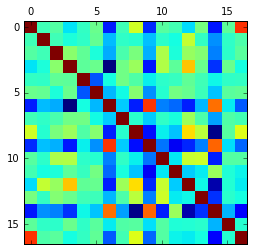

In [18]:
#correlation Heat-Map
plt.matshow(df.corr())

**Inferrence** : 
<br>High correlation attribtue pairs:
<li>Protestors - Political Militia</li>
<li>Protestors - Rioters</li>
<li>Protestors - None</li>

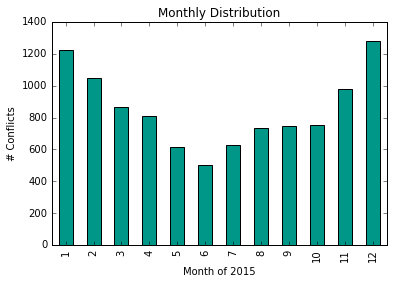

In [19]:
#monthly distribution of conflicts
dft = pd.DatetimeIndex(df['EVENT_DATE']).month
dft = pd.crosstab(dft , columns='month')
plt8 = dft.plot(kind='bar', color = '#009688')
plt8.set(ylabel="# Conflicts", xlabel="Month of 2015", title="Monthly Distribution")
plt8.legend_.remove()

In [20]:
#sample data
crimes3.head()

,EVENT_DATE,EVENT_TYPE,ACTOR1,ALLY_ACTOR_1,INTER1,ACTOR2,ALLY_ACTOR_2,INTER2,COUNTRY,ADMIN1,ADMIN2,ADMIN3,LOCATION,LATITUDE,LONGITUDE,SOURCE,NOTES,FATALITIES
0,01-January-2015,Riots/Protests,Rioters (Bangladesh),AL: Awami League,Rioters,Rioters (Bangladesh),AL: Awami League,Rioters,Bangladesh,Khulna,None,Sharsha,Bagachra,22.95,88.96,United News of Bangladesh,One person was injured in a gunfight between t...,0
1,01-January-2015,Riots/Protests,Protesters (Bangladesh),JeI: Jamaat-e-Islami,Protesters,Police Forces of Bangladesh,None,Government or mutinous force,Bangladesh,Dhaka,None,Dhaka,Dhaka,23.42,90.22,The Financial Express (Bangladesh),The last day of the two-day nationwide shutdow...,0
2,01-January-2015,Riots/Protests,Rioters (Bangladesh),None,Rioters,Rioters (Bangladesh),None,Rioters,Bangladesh,Rangpur,Dinajpur,Parbatipur,Parbatipur,25.66,88.93,The New Nation (Bangladesh),A freedom fighter (FF) was killed and four oth...,1
3,01-January-2015,Battle,Unidentified Communal Group (Bangladesh),None,Ethnic militia,Police Forces of Bangladesh,None,Government or mutinous force,Bangladesh,Sylhet,None,Sunamganj,Sunamganj,25.06,91.40,United News of Bangladesh,"Sunamganj, Jan 2 (UNB) Over 50 people were inj...",0
4,02-January-2015,Riots/Protests,Protesters (Bangladesh),None,Protesters,None,None,None,Bangladesh,Barisal,Patuakhali,None,Patuakhali,22.33,90.33,United News of Bangladesh,Bus owners went on a wildcat indefinite transp...,0


CLASSIFICATION
==============

In [21]:
#Remove actors involved in conflict for predicting Event type
df2 = crimes3.drop(['INTER1' , 'INTER2', 'EVENT_TYPE', 'NOTES'] , axis=1)
df3 = crimes3.EVENT_TYPE

In [22]:
#method to parse and plot sklearn confusion matrix 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

In [23]:
#Stratified sampling of dataset
X = df2
Y = df3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y)
expected = Y_test

#Lable encoding of objects -> numeric_objects
le=LabelEncoder()
for col in X_test.columns.values:
    if X_test[col].dtypes=='object':
       data=X_train[col].append(X_test[col])
       le.fit(data.values)
       X_train[col]=le.transform(X_train[col])
       X_test[col]=le.transform(X_test[col])

In [35]:
#encoded numerical data
X_train.head()

,EVENT_DATE,ACTOR1,ALLY_ACTOR_1,ACTOR2,ALLY_ACTOR_2,COUNTRY,ADMIN1,ADMIN2,ADMIN3,LOCATION,LATITUDE,LONGITUDE,SOURCE,FATALITIES
6350,206,170,835,130,120,2,62,861,1642,2154,23.18,75.77,218,0
1448,267,169,649,130,120,1,93,651,1230,1630,11.56,104.91,173,0
2710,120,170,7,130,120,2,62,206,424,1009,21.82,76.35,73,0
1917,360,195,788,39,0,2,99,217,592,811,30.44,74.88,85,0
2408,163,170,411,146,120,2,21,600,367,520,28.65,77.12,218,0


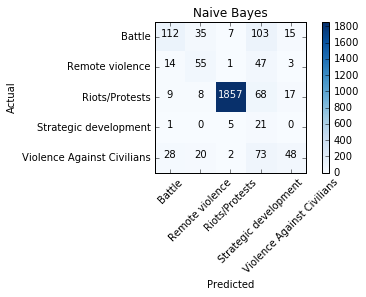

In [24]:
#Train Gaussian Naive Bayes model and get performance measures
model1 = GaussianNB()
model1.fit(X_train, Y_train)
predicted1 = model1.predict(X_test)

cr1 = metrics.classification_report(expected, predicted1)
cm1 = metrics.confusion_matrix(expected, predicted1)

fs1 = f1_score(expected, predicted1, average="macro")
ps1 = precision_score(expected, predicted1, average="macro")
rs1 = recall_score(expected, predicted1, average="macro")
as1 = accuracy_score(expected, predicted1)

plt.figure()
plot_confusion_matrix(cm1, classes=model1.classes_, title='Naive Bayes')

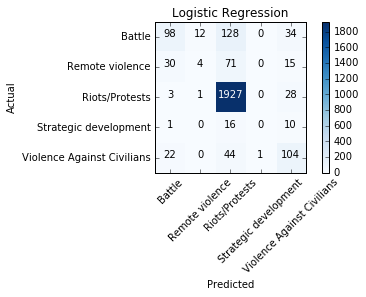

In [25]:
#Train Logistic regression model and get performance measures
model2 = LogisticRegression()
model2.fit(X_train, Y_train)
predicted2 = model2.predict(X_test)

cr2 = metrics.classification_report(expected, predicted2)
cm2 = metrics.confusion_matrix(expected, predicted2)

fs2 = f1_score(expected, predicted2, average="macro")
ps2 = precision_score(expected, predicted2, average="macro")
rs2 = recall_score(expected, predicted2, average="macro")
as2 = accuracy_score(expected, predicted2)
plt.figure()
plot_confusion_matrix(cm2, classes=model2.classes_, title='Logistic Regression')

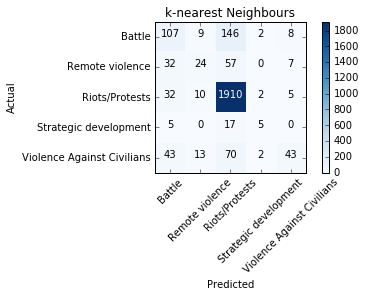

In [26]:
#Train kNN model and get performance measures
model3 = KNeighborsClassifier()
model3.fit(X_train, Y_train)
predicted3 = model3.predict(X_test)

cr3 = metrics.classification_report(expected, predicted3)
cm3 = metrics.confusion_matrix(expected, predicted3)

fs3 = f1_score(expected, predicted3, average="macro")
ps3 = precision_score(expected, predicted3, average="macro")
rs3 = recall_score(expected, predicted3, average="macro")
as3 = accuracy_score(expected, predicted3)
plt.figure()
plot_confusion_matrix(cm3, classes=model3.classes_, title='k-nearest Neighbours')

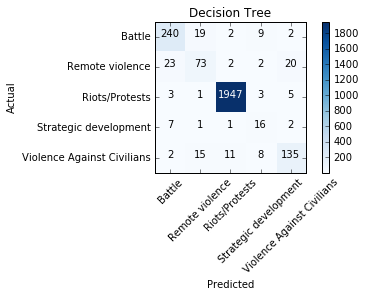

In [27]:
#Train Decision Tree model and get performance measures
model4 = DecisionTreeClassifier()
model4.fit(X_train, Y_train)
predicted4 = model4.predict(X_test)

cr4 = metrics.classification_report(expected, predicted4)
cm4 = metrics.confusion_matrix(expected, predicted4)

fs4 = f1_score(expected, predicted4, average="macro")
ps4 = precision_score(expected, predicted4, average="macro")
rs4 = recall_score(expected, predicted4, average="macro")
as4 = accuracy_score(expected, predicted4)
plt.figure()
plot_confusion_matrix(cm4, classes=model4.classes_, title='Decision Tree')

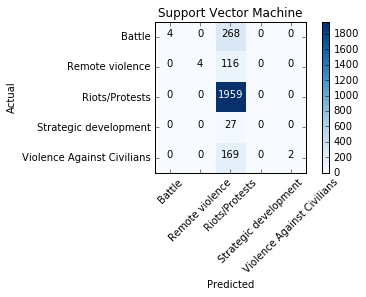

In [28]:
#Train Support Vector Machine model and get performance measures
model5 = SVC()
model5.fit(X_train, Y_train)
predicted5 = model5.predict(X_test)

cr5 = metrics.classification_report(expected, predicted5)
cm5 = metrics.confusion_matrix(expected, predicted5)

fs5 = f1_score(expected, predicted5, average="macro")
ps5 = precision_score(expected, predicted5, average="macro")
rs5 = recall_score(expected, predicted5, average="macro")
as5 = accuracy_score(expected, predicted5)
plt.figure()
plot_confusion_matrix(cm5, classes=model5.classes_, title='Support Vector Machine')

EVALUATING PERFORMANCE
======================

In [29]:
#dictionaries for performance measure of all 5 models
acc_scores = pd.Series([as1, as2, as3, as4, as5])
pre_scores = pd.Series([ps1, ps2, ps3, ps4, ps5])
rec_scores = pd.Series([rs1, rs2, rs3, rs4, rs5])
f1_scores = pd.Series([fs1, fs2, fs3, fs4, fs5])
labels = ['Naive Bayes', 'Logistic Regression', 'kNN', 'Decision Tree', 'SVM']

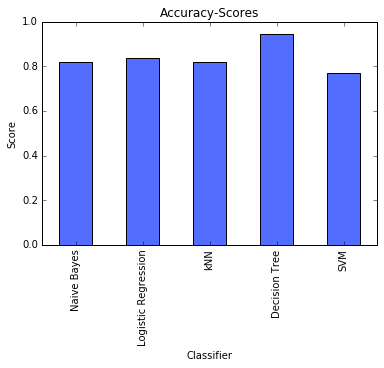

In [30]:
#Accuracy Score Comparison
plt9 = acc_scores.plot(kind='bar', color = '#536dfe')
plt9.set(title = "Accuracy-Scores", xlabel = "Classifier", ylabel = "Score")
plt9.set_xticklabels(labels)

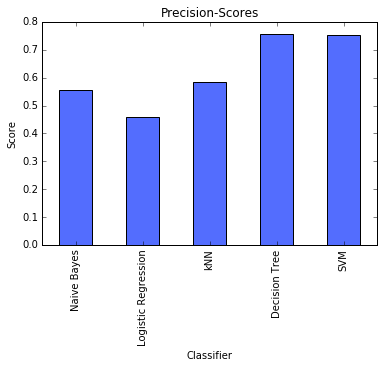

In [31]:
#Precision Score Comparison
plt10 = pre_scores.plot(kind='bar', color = '#536dfe')
plt10.set(title = "Precision-Scores", xlabel = "Classifier", ylabel = "Score")
plt10.set_xticklabels(labels)

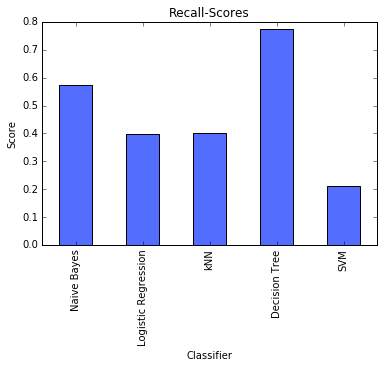

In [32]:
#Recall Score Comparison
plt11 = rec_scores.plot(kind='bar', color = '#536dfe')
plt11.set(title = "Recall-Scores", xlabel = "Classifier", ylabel = "Score")
plt11.set_xticklabels(labels)

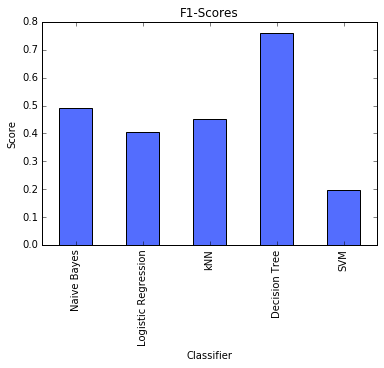

In [33]:
#F1-Score Comparison
plt12 = f1_scores.plot(kind='bar', color = '#536dfe')
plt12.set(title = "F1-Scores", xlabel = "Classifier", ylabel = "Score")
plt12.set_xticklabels(labels)

VISUALIZATION ON GEOGRAPHICAL MAP

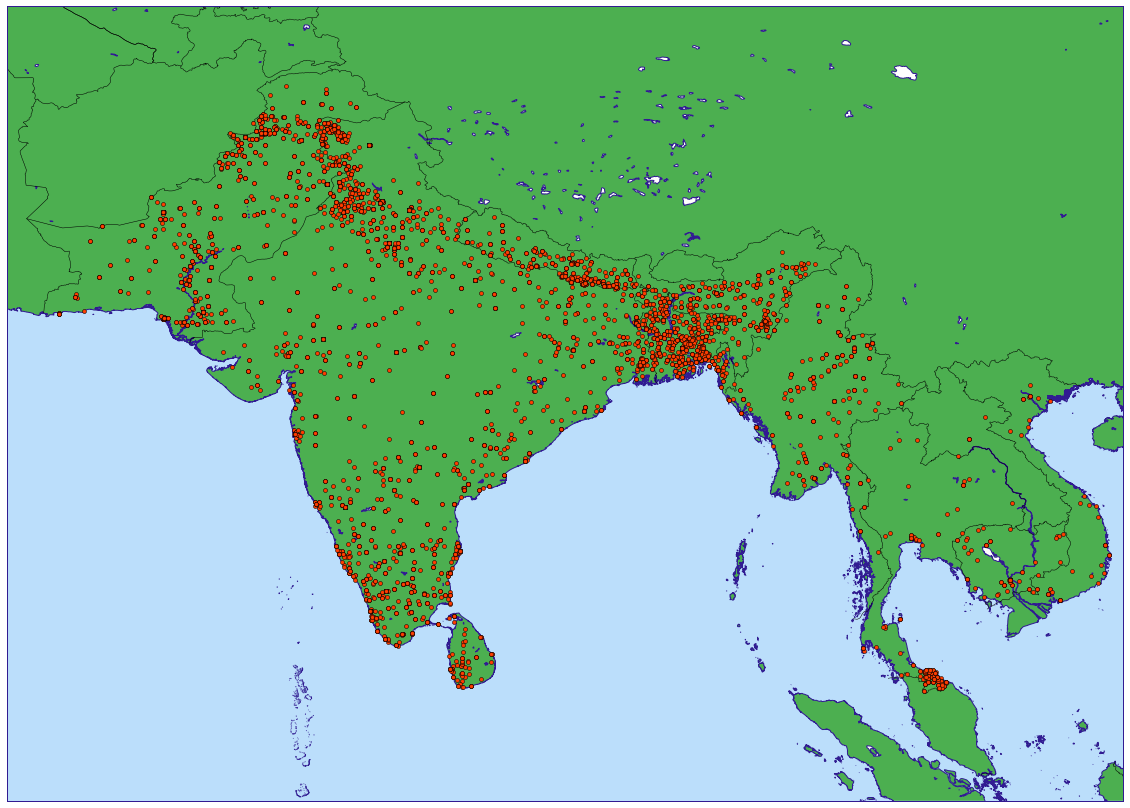

In [34]:
#Plot all conflicts on map
plt.figure(figsize=(20,20))

# background geo map
map = Basemap(projection='gall', lat_0 = 0, lon_0 = 60, resolution = 'h', 
              area_thresh = 0.1, llcrnrlon=60, llcrnrlat=0, urcrnrlon=110, urcrnrlat=40)
 
#draw boundaries
map.drawcoastlines(color = '#311b92')
map.drawcountries()
map.fillcontinents(color = '#4caf50')
map.drawmapboundary(color = '#311b92', fill_color = '#bbdefb')

#plot conflict data points on geo map
lon = np.array(crimes2.LONGITUDE)
lat = np.array(crimes2.LATITUDE)
x,y = map(lon, lat)
map.plot(x, y, 'bo', markersize=4 , color = '#ff3d00')

plt.show()

CONCLUSION
==========
Classifier model for Event type is best given by Decision Tree.